In [1]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.cluster import KMeans
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import itertools
import pandas as pd
import sqlalchemy
import os
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import extract_patches_2d
import warnings
import pymysql
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
conn = pymysql.connect(host='localhost', port=3306, user='root', 
                       passwd='password', db='pitchFX2')

In [3]:
def mins_secs_to_mills(mins, secs):
    return mins * 60 * 1000 + secs * 1000

In [4]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in xrange(0, image.shape[0], stepSize):
		for x in xrange(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0],:])

In [61]:
date_string = '2014-04-17'
columns = ["pitches.ab_id", "pitches.des", "pitches.ball", "pitches.strike", 
           "pitches.on_1b", "pitches.on_2b", "pitches.on_3b",
           "atbats.outs","atbats.event"]
query = ("select {0} "
         "from pitches "
         "join atbats " 
         "on pitches.ab_id = atbats.ab_id "
         "where atbats.ab_id in "
        "(select ab_id from atbats where game_id in "
         "(select game_id "
        "from games where date = '{1}' and home = 'tba')) "
        "order by sv_id").format(",".join(columns), date_string)

In [62]:
query

"select pitches.ab_id,pitches.des,pitches.ball,pitches.strike,pitches.on_1b,pitches.on_2b,pitches.on_3b,atbats.outs,atbats.event from pitches join atbats on pitches.ab_id = atbats.ab_id where atbats.ab_id in (select ab_id from atbats where game_id in (select game_id from games where date = '2014-04-17' and home = 'tba')) order by sv_id"

In [63]:
game_info = pd.read_sql(query, conn)

In [64]:
game_info = game_info.fillna(0)

In [65]:
game_balls = [int(x) for x in game_info['ball']]
game_strikes = [int(x) for x in game_info['strike']]
ab_ids = [int(x) for x in game_info.ab_id]
game_outs = [int(x) for x in game_info.outs]
events = [e.lower() for e in game_info.event]
on_1b = [1 if x > 0 else 0 for x in game_info.on_1b]
on_2b = [1 if x > 0 else 0 for x in game_info.on_2b]
on_3b = [1 if x > 0 else 0 for x in game_info.on_3b]
counts = zip(game_balls, game_strikes)
bases = zip(on_1b, on_2b, on_3b)

In [66]:
des_map = {
    'Ball':'ball',
    'Ball In Dirt':'ball',
    'Called Strike':'strike',
    'Foul':'foul',
    'Foul Bunt':'foul',
    'Foul (Runner Going)':'foul',
    'Foul Tip':'foul',
    'Hit By Pitch':'walk',
    'In play, no out':'play',
    'In play, no out(s)':'play', 
    'In play, out(s)':'out',
    'In play, run(s)':'play',
    'Swinging Strike':'strike',
    'Swinging Strike (Blocked)':'strike'
}

In [67]:
des = [des_map[d] if d in des_map else 'unknown' for d in game_info.des]

In [68]:
set(game_info.des)

{'Ball',
 'Ball In Dirt',
 'Called Strike',
 'Foul',
 'Foul (Runner Going)',
 'Foul Tip',
 'In play, no out',
 'In play, out(s)',
 'In play, run(s)',
 'Swinging Strike'}

In [13]:
def is_pitcher_frame(frame, pitcher_clf, pitcher_kmeans):
    
    gen = sliding_window(cv2.resize(frame,(102, 182), 
                                            interpolation = cv2.INTER_CUBIC), 
                                             stepSize=5, 
                                             windowSize=(8,8))
        
    im_kmeans = np.zeros(20)
    for p in gen:
        if p[2].shape == (8,8,3):
            im_kmeans[pitcher_kmeans.predict(p[2].flatten().reshape(1,-1)[0])] += 1
    
    probs = []
    for clf in pitcher_clf:
        prob = clf.predict_proba(im_kmeans.reshape(1,-1))[0][1]
        probs.append(prob)
    return probs

In [14]:
def is_scoreboard(frame, template, method, clf, kmeans):        
        
        res = cv2.matchTemplate(frame,template,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
    
        selected = frame[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0]]
        
        gen = sliding_window(selected, stepSize=5, windowSize=(8,8))
        
        im_kmeans = np.zeros(40)
        
        for p in gen:
            if p[2].shape == (8,8,3):
                im_kmeans[kmeans.predict(p[2].flatten().reshape(1,-1)[0])] += 1

        probs = clf.predict_proba(im_kmeans)
        return probs, top_left, bottom_right

In [15]:
def classify_outs(sum):
    if sum < 3500:
        return 0
    elif sum < 4500:
        return 1
    else:
        return 2

In [16]:
def get_count_area(frame, top_left, bottom_right):
    selected = frame[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0]]
    res = cv2.matchTemplate(selected,score_area,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left2 = max_loc
    bottom_right2 = (top_left2[0] + w2, top_left2[1] + h2)
    score = selected[top_left2[1]:bottom_right2[1],top_left2[0]:bottom_right2[0]]
    return score

In [17]:
def get_counts_transformed(score, pca, pca2, pca3):       
        
        gray = cv2.cvtColor(score[20:30,18:25],cv2.COLOR_BGR2GRAY).flatten()
        transform = pca.transform(gray).reshape(1,-1)[0]

        gray2 = cv2.cvtColor(score[20:30,27:33],cv2.COLOR_BGR2GRAY).flatten()
        transform2 = pca2.transform(gray2).reshape(1,-1)[0]

        transform3 = pca3.transform(gray).reshape(1,-1)[0]
        return transform, transform2, transform3

In [18]:
def get_outs(score):
    sum = cv2.cvtColor(score[21:29,35:46],cv2.COLOR_BGR2GRAY).sum()
    return classify_outs(sum)

In [19]:
def is_base_occupied(sum):
    return 1 if sum > 2000 else 0

In [31]:
def get_base_status(score):
    first = cv2.cvtColor(score[7:12,40:45],cv2.COLOR_BGR2GRAY).sum()
    second = cv2.cvtColor(score[4:9,35:40],cv2.COLOR_BGR2GRAY).sum()
    third = cv2.cvtColor(score[7:12,32:37],cv2.COLOR_BGR2GRAY).sum()
    return tuple(map(is_base_occupied, [first, second, third]))
    

In [21]:
def scan_cap_ahead(cap, seconds):
    totalSeconds = cap.get(cv2.cv.CV_CAP_PROP_POS_MSEC)
    cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC, int(totalSeconds) + seconds * 1000)

In [103]:
def scan_ahead_info(next_des, strikes, outs, current_bases, next_bases):
    # balls
    # next_des = ball, look for next count
    # next_des = strike
        # if strikes < 2, look for next count
        # elif strikes == 2 and outs < 2, look for out
        # elif strikes == 2 and outs == 2, no scoreboard
    # next_des = out
        # if outs < 2, look for next out situation
        # else look for no scorebox
    # still need to figure out balls in play, look at baserunners
    if next_des == 'ball':
        return 'ball'
    elif next_des == 'strike':
        if strikes < 2:
            return 'strike'
        else:
            if outs < 2:
                return 'next_out'
            else:
                return 'final_out'
    elif next_des == 'foul' and strikes < 2:
        return 'strike'
    elif next_des == 'out':
        if outs < 2:
            return 'next_out'
        else:
            return 'final_out'
    elif next_des == 'play':
        if next_bases == current_bases:
            return 'score_change'
        else:
            return 'bases' 
    else:
        return 'unknown'

In [147]:
start_time = mins_secs_to_mills(3,11)
cap = cv2.VideoCapture('videos/rays-cards-06-11-2014.mov')
cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC, start_time)

True

In [148]:
pitcher_kmeans = pickle.load(open('models/pitching-view-kmeans.pkl'))
pitcher_clf = pickle.load(open('models/pitcher-clf.pkl'))
pitcher_clf2 = pickle.load(open('models/pitcher-shot-classifier.pkl'))
pitcher_clfs = [pitcher_clf]
fast_forward = True
fast_forward_speed = 60
show_video = True
time_stamps = []

while(1):
        
    ret, frame = cap.read()
    if not ret:
        break
    
    if show_video:    
        cv2.imshow('frame',frame)
        
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    if fast_forward:
        totalFrameNumber = cap.get(cv2.cv.CV_CAP_PROP_POS_FRAMES)
        cap.set(cv2.cv.CV_CAP_PROP_POS_FRAMES, int(totalFrameNumber) + fast_forward_speed)
        
    pitcher_probs = is_pitcher_frame(frame, pitcher_clfs, pitcher_kmeans)
    if pitcher_probs[0] >= 0.2:
        print pitcher_probs[0]
        sys.stdout.flush()
        fast_forward_speed = 20
        time_stamps.append(cap.get(cv2.cv.CV_CAP_PROP_POS_MSEC))
        while True:
            ret, frame = cap.read()

            cv2.imshow('frame',frame)
            
            scan_cap_ahead(cap, 0.5)
        
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            pitcher_probs = is_pitcher_frame(frame, pitcher_clfs, pitcher_kmeans)
            if pitcher_probs[0] < .01:
                fast_forward_speed = 60
                print pitcher_probs[0]
                sys.stdout.flush()
                time_stamps.append(cap.get(cv2.cv.CV_CAP_PROP_POS_MSEC))
                break



0.530942318483
5.36103733315e-14
0.297933757745
4.78269155218e-11
0.216301268662
1.22806011537e-14
0.517492809411
5.01312957119e-08
0.204827792387
4.58148320112e-09
0.405162011691
0.000848264471422
0.727051963804
3.36973911368e-06
0.611165150004
5.504834539e-07
0.69595863056
3.10573987023e-08
0.550148444938
3.20976155076e-14
0.780461401739
5.17086515437e-10
0.65350535517
8.70846556543e-13
0.707495862219
4.885003996e-06
0.642555414355
1.61859621366e-09
0.56476861546
2.61142897664e-11
0.389961388083
9.36474422585e-06
0.568420432172
4.70813301859e-20
0.292764814747
2.00316587081e-18
0.443979102148
1.12142878602e-10
0.779072568778
3.9378372088e-12
0.467177990097
5.32624831779e-13
0.442003530042
1.11623370318e-15
0.496209554857
2.75055224777e-16
0.771087524444
1.58282506293e-10
0.288000486046
7.31952663029e-06
0.323846451621
8.22553567017e-13
0.339973800658
2.33475940653e-13
0.541567138757
0.00403435242174
0.544215803388
0.000502339120261
0.596193360301
0.00247293468536
0.802636113027
4.091

KeyboardInterrupt: 

In [149]:
time_stamps = np.array(time_stamps)
firsts = np.array(time_stamps[::2])
seconds = np.array(time_stamps[1::2])

In [150]:
diffs = seconds - firsts

In [151]:
firsts = firsts[diffs > 3000]
seconds = seconds[diffs > 3000]

In [152]:
diffs

array([  6999.5       ,   8516.16666667,   9999.5       ,   4499.5       ,
         9999.5       ,   8999.5       ,  10499.5       ,   5999.5       ,
         4516.16666667,   9516.16666667,   5499.5       ,  16499.5       ,
        11999.83333333,  10999.83333333,   7499.83333333,    499.83333333,
         4499.83333333,   8499.83333333,   5499.83333333,   2999.83333333,
         5016.16666667,   3999.5       ,   3499.83333333,    499.5       ,
         5516.16666667,   5016.16666667,   3499.5       ,   5999.83333333,
          500.16666667,   3499.83333333,    999.5       ,   3499.5       ,
        10999.5       ,   3999.5       ,   4999.5       ])

In [153]:
diffs = firsts[1:] - firsts[:-1]
inning_breaks = [x[0] for x in np.argwhere(diffs > 100000)]

In [110]:
template = pickle.load(open('data/rays-scoreboard'))
score_area = pickle.load(open('data/game-info'))
w,h = template.shape[1], template.shape[0]
w2,h2 = score_area.shape[1], score_area.shape[0]
method = 'cv2.TM_CCOEFF'
method = eval(method)
scoreboard_clf = pickle.load(open('models/scoreboard-clf.pkl'))
scoreboard_kmeans = pickle.load(open('models/scoreboard-kmeans.pkl'))
pca = pickle.load(open('models/count1-pca.pkl'))
neighs = pickle.load(open('models/count1-clf.pkl'))
pca2 = pickle.load(open('models/count2-pca.pkl'))
neighs2 = pickle.load(open('models/count2-clf.pkl'))
pca3 = pickle.load(open('models/two-three-pca.pkl'))
two_three = pickle.load(open('models/two-three-clf.pkl'))
pitcher_kmeans = pickle.load(open('models/pitching-view-kmeans.pkl'))
pitcher_clf = pickle.load(open('models/pitcher-clf.pkl'))
pitcher_clfs = [pitcher_clf]
located_scorebox = False
top_left = None
bottom_right = None
tops = []
bottoms = []
min_boxes = 20
fast_forward = True
fast_forward_speed = 200
pitching_view = False
show_video = True
seconds_to_move = 10
next_count = counts[1]
next_event = des[0]
scan_ahead = None
final_out = True
one_game_score = False
start = firsts[0]
starts = []
ends = []
started = False
breaks = 0
time_stamp = 0
i = 0
pitches = 0
j = 0

while(1):
    j += 1
   
    to_look_for = scan_ahead_info(des[pitches], 
                                  counts[pitches][1], 
                                  game_outs[pitches] - 1,
                                  bases[pitches],
                                  bases[pitches + 1]
                                             )
    
    if j % 100 == 0:
        if to_look_for != 'score_change':
            probs, _, _ = is_scoreboard(frame, template, method, scoreboard_clf, scoreboard_kmeans)
            if probs[0][1] >= 0.3:
                score = get_count_area(frame, top_left, bottom_right)
                game_score = score[3:30,:12]
                game_score = int(cv2.cvtColor(game_score,cv2.COLOR_BGR2GRAY).sum())
    
        print "looking for {}".format(des[pitches])
        sys.stdout.flush()
    
    if to_look_for == 'final_out' and final_out:
        while firsts[inning_breaks[breaks]] < timestamp:
            breaks += 1
        cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC, firsts[inning_breaks[breaks]])
        i = inning_breaks[breaks]
        final_out = False
    
    timestamp = cap.get(cv2.cv.CV_CAP_PROP_POS_MSEC)
    
    if started:
        while i < (len(firsts)-1) and firsts[i+1] < timestamp:
            i += 1
            print i
            if i == len(firsts):
                break
            start = firsts[i]
    
    ret, frame = cap.read()
    if not ret:
        break
    
    if show_video:    
        cv2.imshow('frame',frame)
        
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
    if fast_forward:
        totalFrameNumber = cap.get(cv2.cv.CV_CAP_PROP_POS_FRAMES)
        cap.set(cv2.cv.CV_CAP_PROP_POS_FRAMES, int(totalFrameNumber) + fast_forward_speed)
        
    if not located_scorebox:
        
        probs, top_left, bottom_right = (
            is_scoreboard(frame, template, method, scoreboard_clf, scoreboard_kmeans))

        if probs[0][1] >= 0.5:
            
            if not located_scorebox:
                tops.append(top_left)
                bottoms.append(bottom_right)
                if len(tops) == min_boxes:
                    top_left = sorted(tops)[min_boxes/2]
                    bottom_right = sorted(bottoms)[min_boxes/2]
                    cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC,firsts[0] - 2000)
                    located_scorebox = True
                    fast_forward_speed = 10
                    started = True
                    print "located scoreboard"
                    sys.stdout.flush()
        continue        
    
    if to_look_for in ['ball', 'strike']:
        
        probs, _, _ = is_scoreboard(frame, template, method, scoreboard_clf, scoreboard_kmeans)
        if probs[0][1] < 0.3:
            continue
        score = get_count_area(frame, top_left, bottom_right)
        
        transform, transform2, transform3 = (
            get_counts_transformed(score, pca, pca2, pca3))
        
        balls = neighs.predict(transform)[0]
        strikes = neighs2.predict(transform2)[0]
        
        if balls in [2,3]:
            balls = two_three.predict(transform3)[0]

        if balls == 4 and strikes == 4:
            balls = 0
            strikes = 0

        if (balls,strikes) == counts[pitches+1]:
            print "{} found".format(des[pitches])
            sys.stdout.flush()
            pitches += 1
            starts.append(start)
            ends.append(cap.get(cv2.cv.CV_CAP_PROP_POS_MSEC))
            if i == (len(firsts) - 1):
                break
            cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC,firsts[i+1] - 2000)
        continue
    
    elif to_look_for == 'next_out':
        probs, _, _ = is_scoreboard(frame, template, method, scoreboard_clf, scoreboard_kmeans)
        if probs[0][1] < 0.3:
            continue
        sys.stdout.flush()
        score = get_count_area(frame, top_left, bottom_right)
        outs = get_outs(score)
        if outs == game_outs[pitches]:
            print "found out"
            sys.stdout.flush()
            pitches += 1
            starts.append(start)
            ends.append(cap.get(cv2.cv.CV_CAP_PROP_POS_MSEC))
            if i == (len(firsts) - 1):
                break
            cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC,firsts[i+1] - 2000)

        continue
     
    elif to_look_for == 'bases':
        probs, _, _ = is_scoreboard(frame, template, method, scoreboard_clf, scoreboard_kmeans)
        if probs[0][1] < 0.3:
            continue
        
        score = get_count_area(frame, top_left, bottom_right)
        base_status = get_base_status(score)
        
        sys.stdout.flush()
        if base_status == bases[pitches+1]:
            print "found play"
            sys.stdout.flush()
            pitches += 1
            end = cap.get(cv2.cv.CV_CAP_PROP_POS_MSEC)
            if end - start < 3000:
                start = firsts[i-1]
            starts.append(start)
            ends.append(end)
            if i == (len(firsts) - 1):
                break
            cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC,firsts[i+1] - 2000)


        continue    
        
    elif to_look_for == 'score_change':
        probs, _, _ = is_scoreboard(frame, template, method, scoreboard_clf, scoreboard_kmeans)
        if probs[0][1] < 0.3:
            continue
        
        score = get_count_area(frame, top_left, bottom_right)
        this_score = score[3:30,:12]
        this_score = int(cv2.cvtColor(this_score,cv2.COLOR_BGR2GRAY).sum())
        diff = abs(this_score - game_score)

        if diff > 1000:
            print "found score"
            sys.stdout.flush()
            pitches += 1
            end = cap.get(cv2.cv.CV_CAP_PROP_POS_MSEC)
            if end - start < 3000:
                start = firsts[i-1]
            starts.append(start)
            ends.append(end)
            if i == (len(firsts) - 1):
                break
            cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC,firsts[i+1] - 2000)


        continue    
    
    elif to_look_for == 'final_out':        
        probs, _, _ = is_scoreboard(frame, template, method, scoreboard_clf, scoreboard_kmeans)
        if probs[0][1] < 0.01:
            print "found last out"
            sys.stdout.flush()
            starts.append(firsts[inning_breaks[breaks]])
            ends.append(cap.get(cv2.cv.CV_CAP_PROP_POS_MSEC))
            pitches += 1
            breaks += 1
            final_out = True
            if i == (len(firsts) - 1):
                break
            cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC,firsts[i + 1] - 2000)
    
    else:
        if i == (len(firsts) -1):
            break
        cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC,firsts[i+2] - 2000)
        pitches += 1

located scoreboard
looking for strike
strike found
1
looking for foul
foul found
2
ball found
3
looking for play
4
found play
looking for ball
5
ball found
6
looking for ball
7
looking for ball
looking for ball
8
9
looking for ball
ball found
10
looking for ball
ball found
11
strike found
12
looking for ball
looking for ball
looking for ball
13
ball found
14
looking for out
found out
15
looking for ball
ball found
16
looking for ball
looking for ball
17
looking for ball
ball found
18
looking for strike
strike found
19
foul found
looking for strike
20
looking for strike
looking for strike
found out
21
looking for play
looking for play
looking for play
22
looking for play
found play
23
looking for ball
24
looking for ball
looking for ball
25
ball found
26
looking for strike
strike found
27
looking for strike
strike found
28
looking for ball
ball found
found last out
31
looking for strike
strike found
32
strike found
33
looking for out
34
found out
35
looking for foul
foul found
36
strike

IndexError: index 74 is out of bounds for axis 0 with size 74

In [158]:
for s,e in zip(firsts[17:], seconds[17:]):
    cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC, s)
    while cap.get(cv2.cv.CV_CAP_PROP_POS_MSEC) < e:
        ret, frame = cap.read()
        cv2.imshow('frame', frame)
        frame = cv2.flip(frame,0)
        
        scan_cap_ahead(cap, 0.03)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

KeyboardInterrupt: 

In [374]:
def mills_to_hours_mins_secs(mills):
    seconds = int(mills / 1000) % 60
    minutes = int((mills / (1000*60)) % 60)
    hours   = int((mills / (1000*60*60)) % 24)
    return hours, minutes, seconds

In [376]:
mills_to_hours_mins_secs(ends[0])

(0, 3, 53)

In [871]:
firsts = np.array(time_stamps[::2])
seconds = np.array(time_stamps[1::2])

In [ ]:
labels = np.zeros(len(scoreboards))

In [15]:
is_pitcher_frame(frame, pitcher_clf, pitcher_kmeans)

0.38

In [592]:
is_scoreboard = [18, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 
                 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 
                 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 
                 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 
                 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 100, 101, 102, 103, 
                 104, 105, 106, 107, 108, 109, 113, 114, 115, 116, 117, 118, 
                 120, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 
                 154, 155, 156, 157, 161, 162, 163, 164, 165, 166, 167, 170, 
                 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 200,
                 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 215, 216,
                 217, 218, 219, 220, 221, 222, 223, 224, 225, 229, 230, 231, 
                 232, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 
                 245, 246, 247, 250, 251, 252, 253, 254, 255, 256, 257, 258, 
                 259, 260, 261, 262, 263, 267, 268, 269, 270, 271, 272, 273, 
                 274, 275]

In [594]:
labels[is_scoreboard] = 1

In [495]:
start_time = mins_secs_to_mills(2,30)
cap = cv2.VideoCapture('videos/rays-as-05-20-2014.mov')
cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC, start_time)

True

In [47]:
ret, img = cap.read()

In [48]:
ret

True

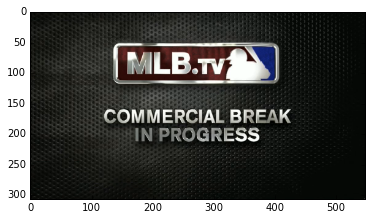

In [49]:
plt.imshow(img)

In [1350]:
pickle.dump(rays_template, open('data/rays-scoreboard','wb'))

In [662]:
template = pickle.dump(template, open('data/rays-scoreboard','wb'))

In [663]:
template = pickle.load(open('data/rays-scoreboard','rb'))

In [1359]:
w,h = template.shape[1], template.shape[0]

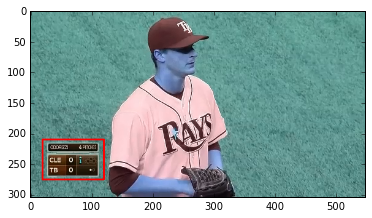

In [1366]:
plt.imshow(img)

In [1697]:
start_time = mins_secs_to_mills(6,14)
cap = cv2.VideoCapture('rays-indians-05-09-2014.mov')
cap.set(cv2.cv.CV_CAP_PROP_POS_MSEC, start_time)

True

In [1192]:
ret, img = cap.read()

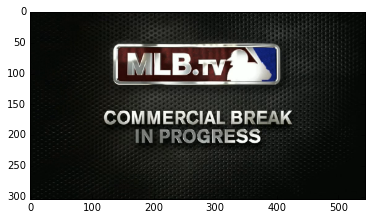

In [1193]:
plt.imshow(img)

In [34]:
score_area = img[213:277,24:115][23:58,37:86])

NameError: name 'img' is not defined

In [715]:
pickle.dump(score_area, open('data/game-info','wb'))

In [1397]:
method = 'cv2.TM_CCOEFF'
method = eval(method)
res = cv2.matchTemplate(img,template,method)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img,top_left, bottom_right, 255, 2)

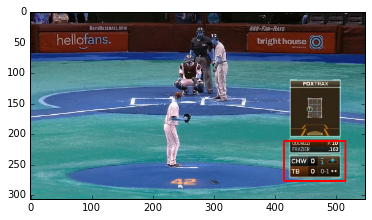

In [1398]:
plt.imshow(img)

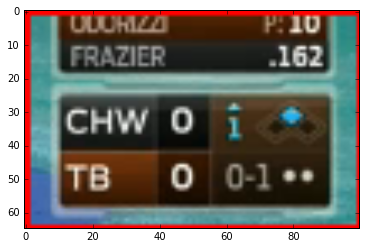

In [1410]:
plt.imshow(img[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0]])

In [1517]:
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(imgs2, labs)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1518]:
pickle.dump(rf, open('scoreboard-clf.pkl','wb'))

In [1516]:
np.mean(rf.predict(imgs2[70:]) == labs[70:])

0.96875

In [90]:
all_scoreboards = all_scoreboards.extend(scoreboards)

In [17]:
score_area = template[23:57,35:86]

In [96]:
pickle.dump([scoreboards,labels], open('data/sb-04-2014','wb'))

In [102]:
pickle.dump([scoreboards,labels], open('data/sb-04-17-2016','wb'))

In [596]:
pickle.dump([scoreboards,labels], open('data/sb-04-17-2014','wb'))

In [1910]:
s1,l1 = pickle.load(open('data/sb-04-2014','rb'))
s2,l2 = pickle.load(open('data/sb-04-17-2016','rb'))
s3,l3 = pickle.load(open('data/sb-04-17-2014','rb'))

In [1911]:
imgs = []
for im in itertools.chain(s1, s2, s3):
    imgs.append(im)

In [1864]:
labels = np.concatenate((l1,l2,l3))

In [1865]:
labels.shape

(508,)

In [1731]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in xrange(0, image.shape[0], stepSize):
		for x in xrange(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0],:])

In [1878]:
def extract_patches_and_features(imgs, patch_size, n_clusters):
    
    patches = []
    for im in imgs:
        patchs = extract_patches_2d(im, patch_size, max_patches=20)
        for p in patchs:
            patches.append(p.flatten())
    
    patches = np.array(patches)
    
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(patches)
    
    out = np.zeros((len(imgs), n_clusters))
    
    for i in range(len(imgs)):
        gen = sliding_window(imgs[i], stepSize=5, windowSize=patch_size)
        im_kmeans = np.zeros(n_clusters)
        for p in gen:
            if p[2].shape == (patch_size[0], patch_size[1] ,3):
                im_kmeans[kmeans.predict(p[2].flatten().reshape(1,-1)[0])] += 1
        out[i] = im_kmeans
        
    return out, kmeans

In [2124]:
out, kmeans = extract_patches_and_features(imgs, (8,8), 40)

In [90]:
def test_classifier(ftrs, labs, clf, percent=0.7):
    perm = np.random.permutation(len(labs))
    ftrs = ftrs[perm,:]
    labs = labs[perm]

    num = int(percent * len(labs))
    clf.fit(ftrs[:num], labs[:num])
    
    return np.mean(clf.predict(ftrs[num:]) == labs[num:])

In [2125]:
rf = RandomForestClassifier(n_estimators=20)
rf.fit(out, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [636]:
pickle.dump(rf, open('scoreboard-clf.pkl','wb'))

In [637]:
pickle.dump(kmeans, open('scoreboard-kmeans.pkl','wb'))

In [1095]:
first_nums = [cv2.cvtColor(s[20:30,18:25],cv2.COLOR_BGR2GRAY).flatten() for s in score_areas]

In [1096]:
second_nums = [cv2.cvtColor(s[20:30,27:33],cv2.COLOR_BGR2GRAY).flatten() for s in score_areas]

In [79]:
count_map = {
    0:'00', 
    1:'01', 
    2:'02', 
    3:'10',
    4:'11',
    5:'12',
    6:'20',
    7:'21',
    8:'22',
    9:'30',
    10:'31',
    11:'32'
}

In [1993]:
n1, l1 = pickle.load(open('data/score-areas1'))
n2, l2 = pickle.load(open('data/score-areas2'))

In [297]:
def get_count_labs(ls, count_map, first=True):
    if first:
        return [4 if count_map[l] == '00' else int(count_map[l][0]) for l in ls]
    else:
        return [4 if count_map[l] == '00' else int(count_map[l][1]) for l in ls]

In [298]:
def collect_labels(labs_lst, count_map, first=True):
    coll = []
    for labs in labs_lst:
        coll.append(get_count_labs(labs, count_map, first))
    return np.concatenate(tuple(coll))

In [296]:
def load_count_data(folder, files):
    ims = []
    labs = []
    for f in files:
        im, l = pickle.load(open(os.path.join(folder,f)))
        ims.append(im)
        labs.append(l)
    return ims, labs

In [299]:
folder = '/Users/jonadelson/Columbia/BaseballHighlights/data'
files = ['score-areas1', 'score-areas2']
ims, labs = load_count_data(folder, files)

In [984]:
labs1 = collect_labels(labs, count_map, first=True)
labs2 = collect_labels(labs, count_map, first=False)

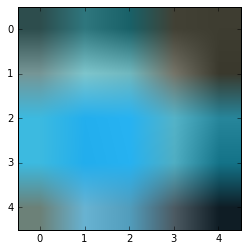

In [629]:
plt.imshow(ims[0][50][7:12,32:37])

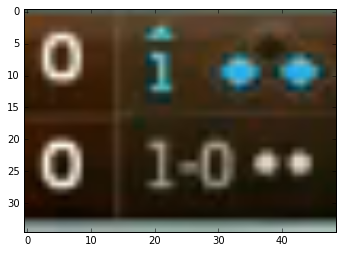

In [626]:
plt.imshow(ims[0][50])

In [630]:
bases = [[[7,12],[40,45]],[[4,9], [35,40]],[[7,12],[32,37]]]  

In [631]:
base_ims = []
for coords in bases:
    base_ims.append(get_count_section(ims, coords[0], coords[1]))

In [639]:
for i in base_ims[0]:
    print i.sum()

1003
995
1000
1011
3257
3321
3285
3309
3302
3293
3307
3331
3314
3331
3312
3298
3296
3289
3329
1052
1051
1102
1067
1068
1056
1062
1050
1069
1026
3347
3344
3348
3340
3348
3349
3336
3360
3339
3355
3346
3332
3359
3376
3364
3375
3324
3269
3304
3331
3317
3294
3308
3294
3296
3305
3314
3324
3297
3299
3327
3298
3282
3292
3319
3339
3268
3312
3316
3310
997
3310
3310
3296
3307
3307
3310
3291
3298
3262
3278
3325
3294
3291
3309
3289
3307
3343
3308
3289
1054
1067
1058
1055
1055
1049
1054
1041
1031
1040
1016
1013
1032
1015
1019
1014
1019
1054
1011
1017
986
993
1025
1010
1021
1019
996
1017
1064
1013
1002
1007
990
1014
1031
996
1014
1044
3205
3329
3318
3296
3308
3265
3294
3273
3308
3296
3293
3324
3306
3295
3284
3266
3315
3322
3300
3277
3292
3296
3311
3326
3264
3308
3318
966
991
1000
1006
1005
984
987
3304
3333
3285
3267
3293
3308
3286
3293
3303
3323
3305
3327
3332
3296
3303
3307
3277
1015
1016
1014
990
990
946
972
3308
3339
3305
3283
3308
3349
3317
3210
1033
1008
1022
985
1005
987
1009
1007
1027
1019
10

In [302]:
def get_count_section(ims, x_area, y_area):
    out = []
    for im in ims:
        transform = [cv2.cvtColor(s[x_area[0]:x_area[1],y_area[0]:y_area[1]],
                                  cv2.COLOR_BGR2GRAY).flatten() for s in im]
        out.append(transform)
    return np.concatenate(tuple(out))

In [307]:
outs = get_count_section(ims, [21,29],[35,46])

0


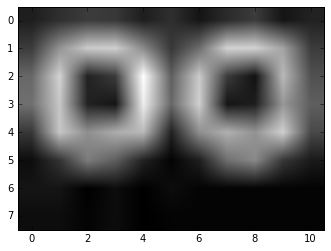

1


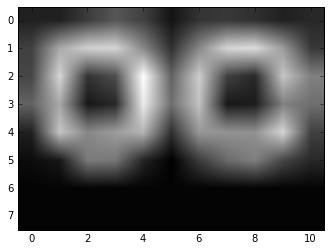

2


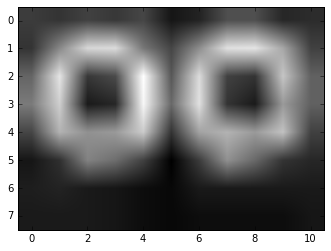

3


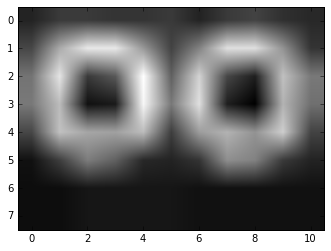

4


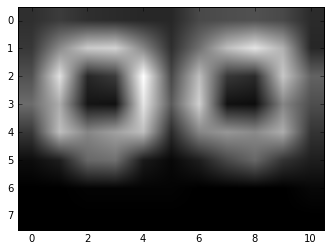

5


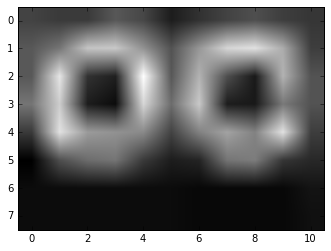

6


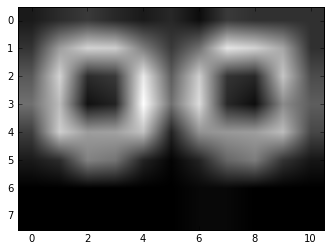

7


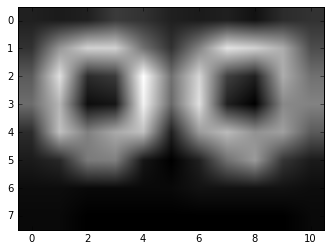

8


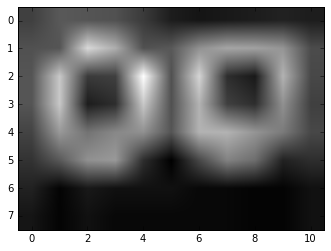

9


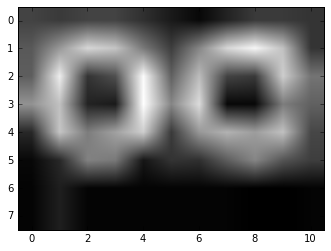

10


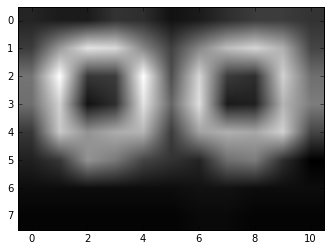

11


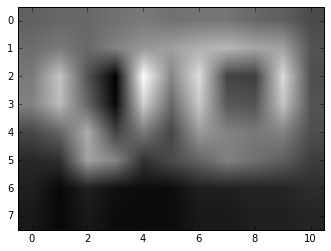

12


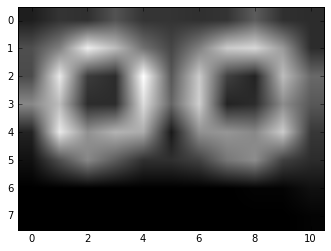

13


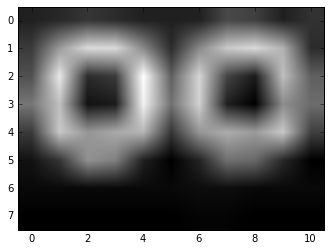

14


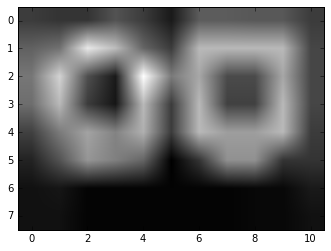

15


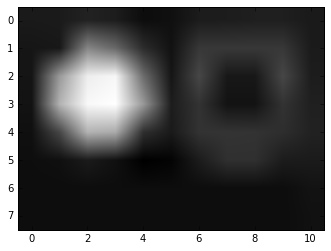

16


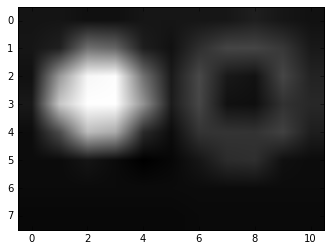

17


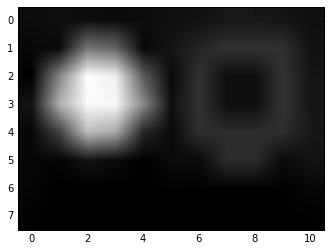

18


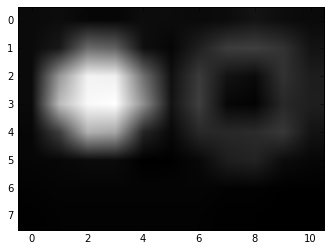

19


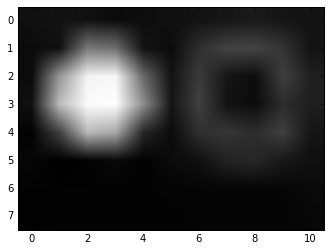

20


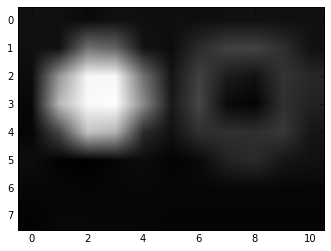

21


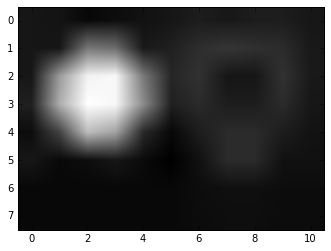

22


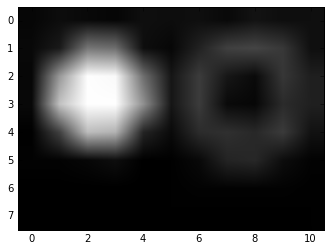

23


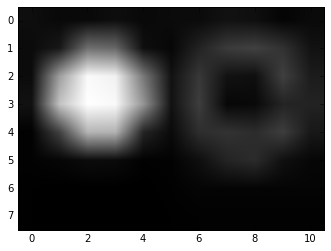

24


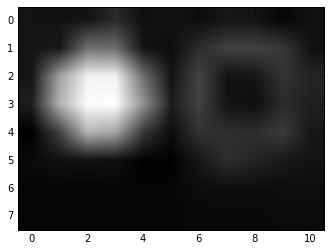

25


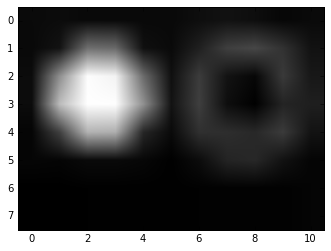

26


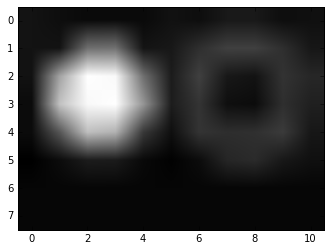

27


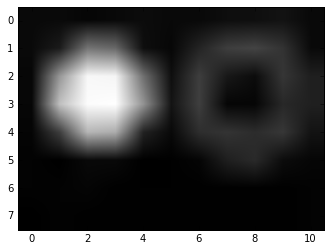

28


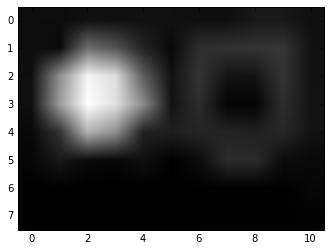

29


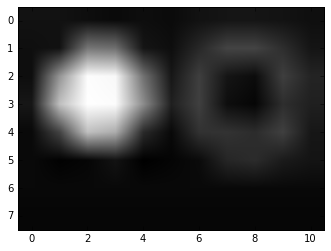

30


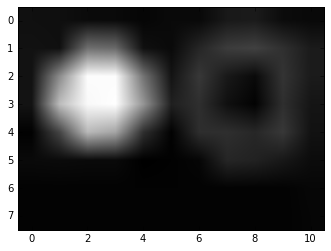

31


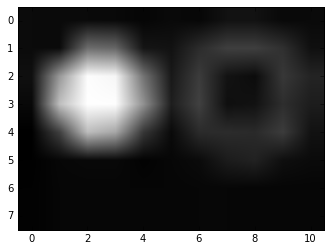

32


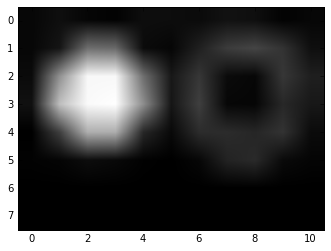

33


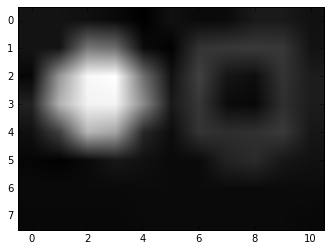

34


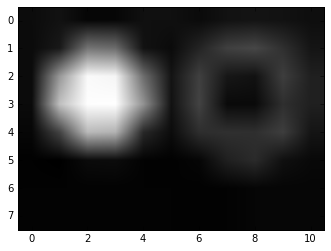

35


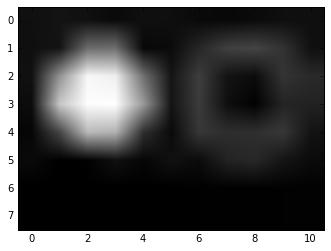

36


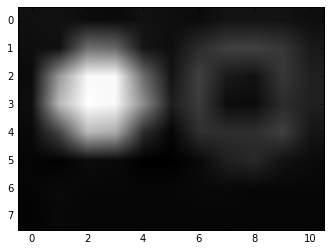

37


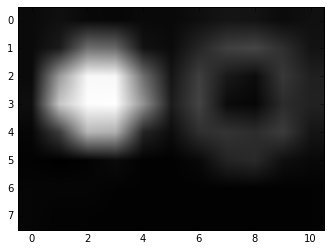

38


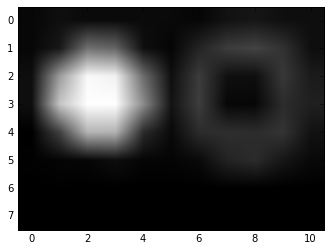

39


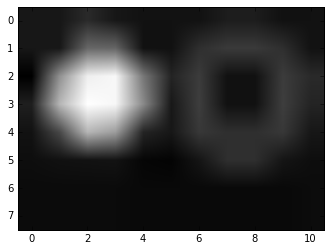

40


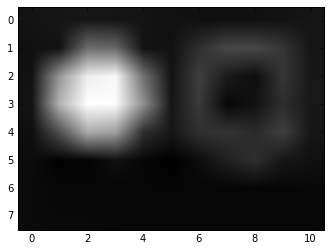

41


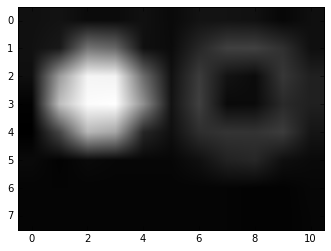

42


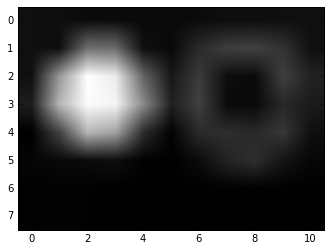

43


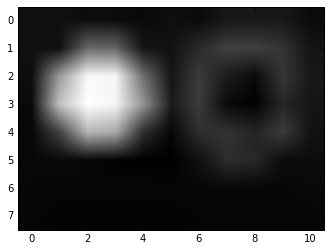

44


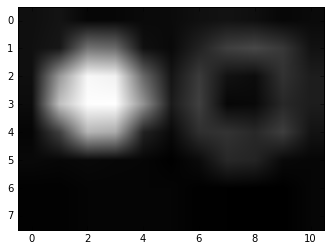

45


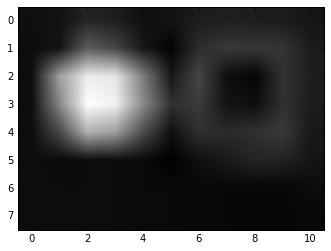

46


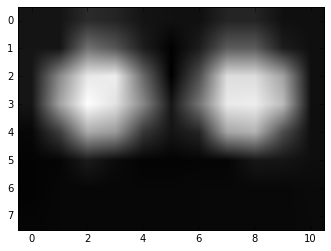

47


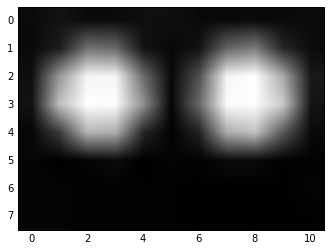

48


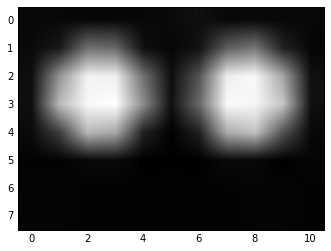

49


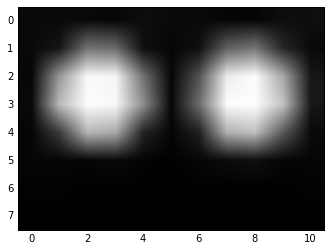

50


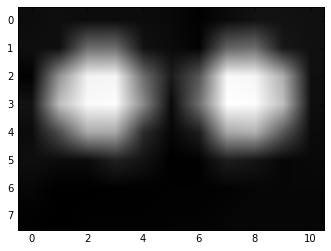

51


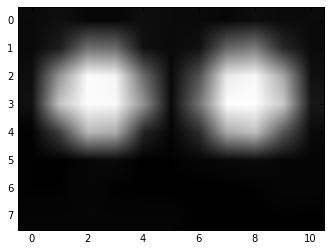

52


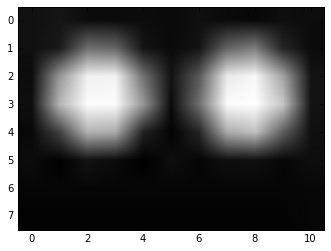

53


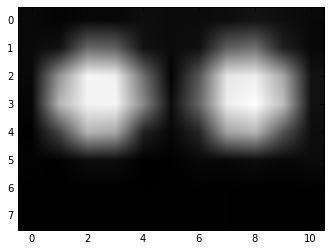

54


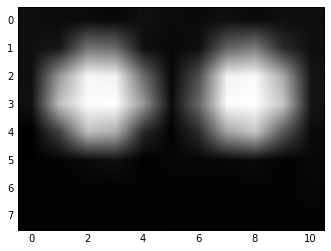

55


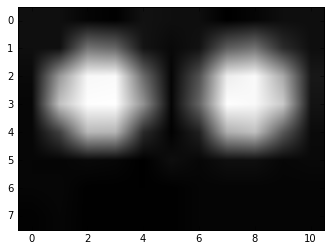

56


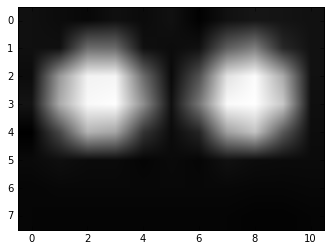

57


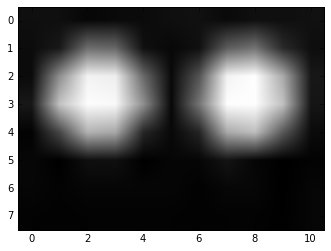

58


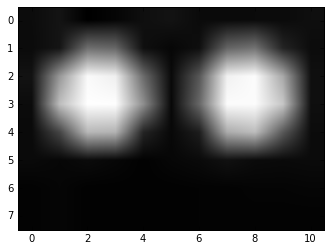

59


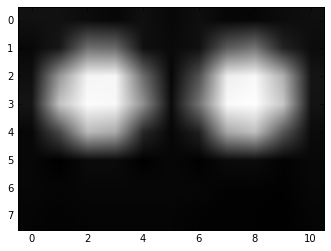

60


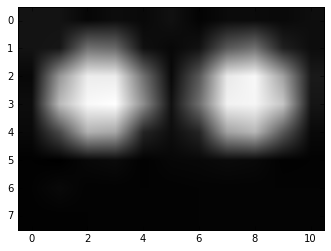

61


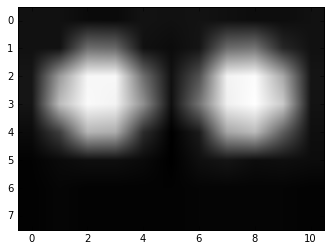

62


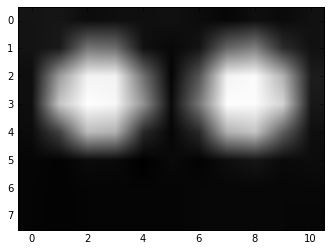

63


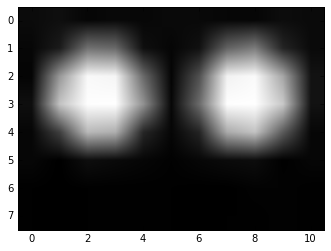

64


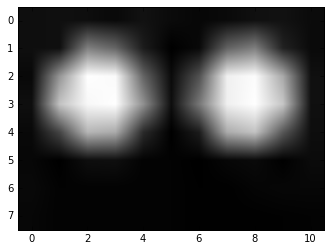

65


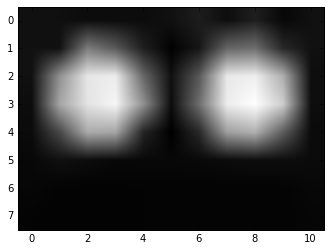

66


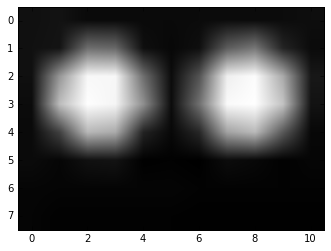

67


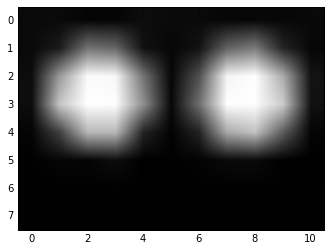

68


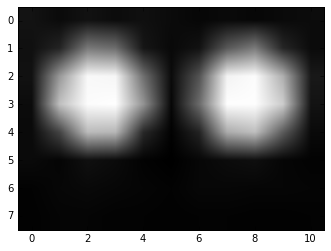

69


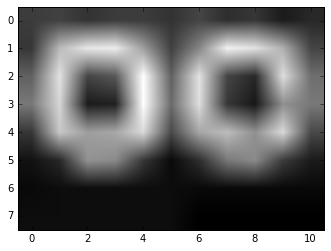

70


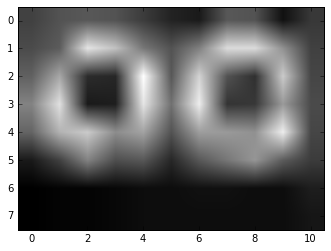

71


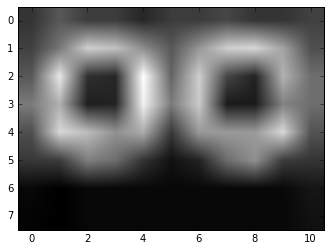

72


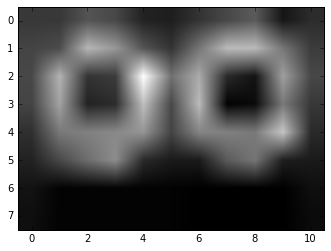

73


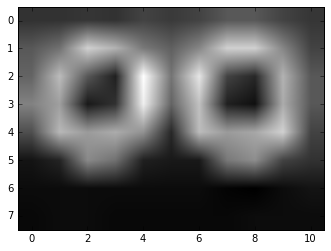

74


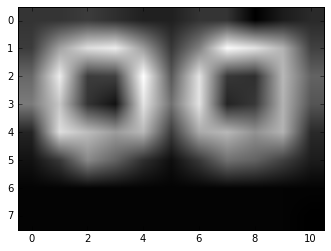

75


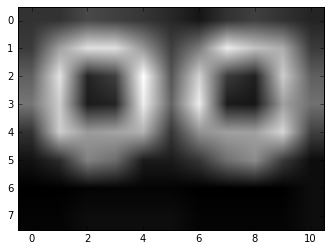

76


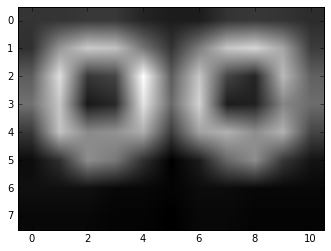

77


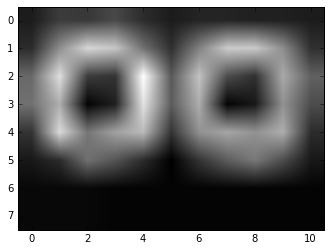

78


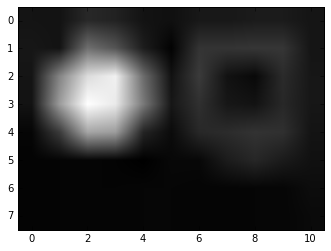

79


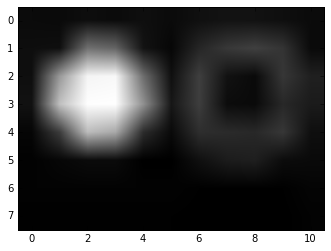

80


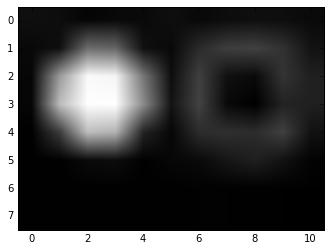

81


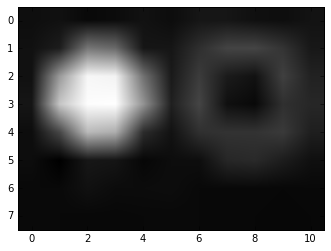

82


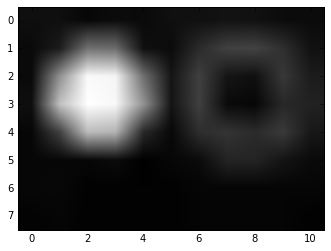

83


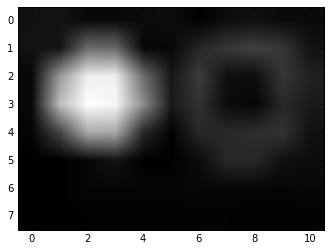

84


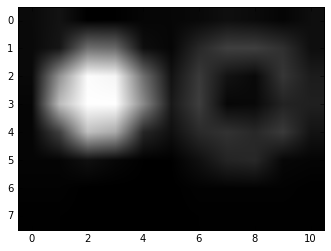

85


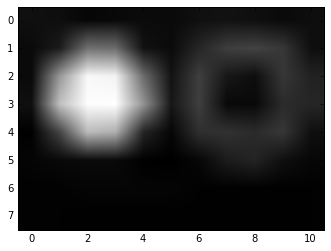

86


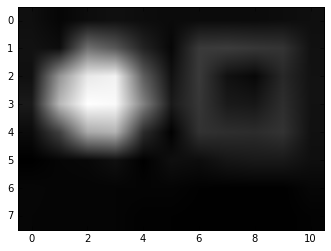

87


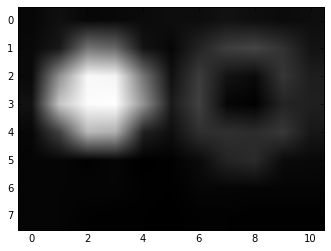

88


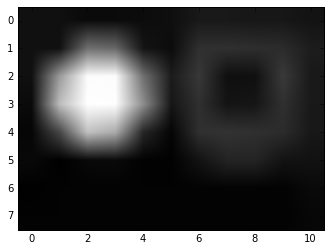

89


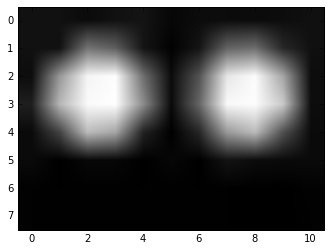

90


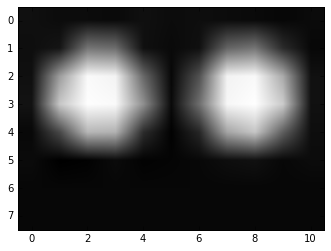

91


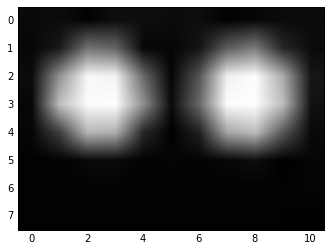

92


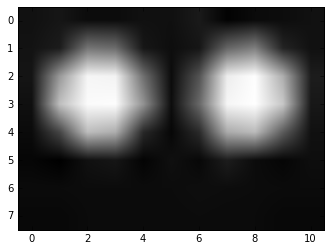

93


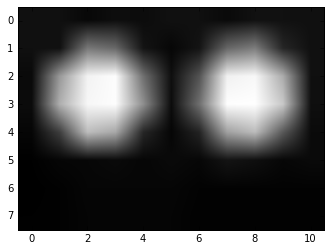

94


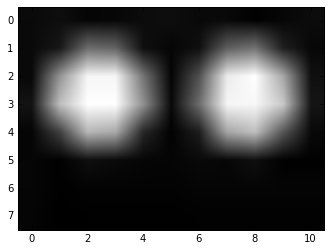

95


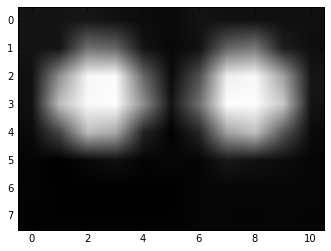

96


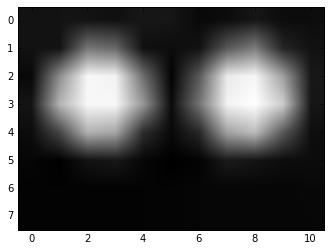

97


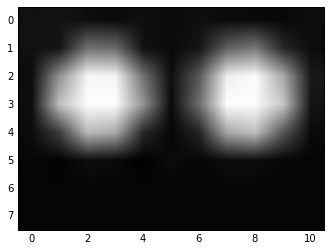

98


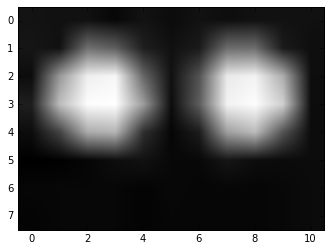

99


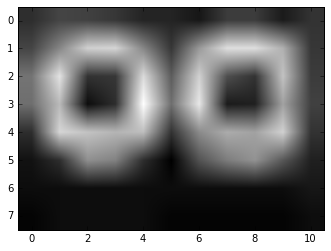

100


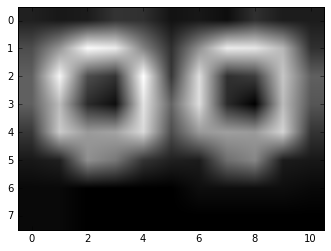

101


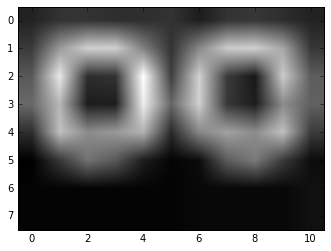

102


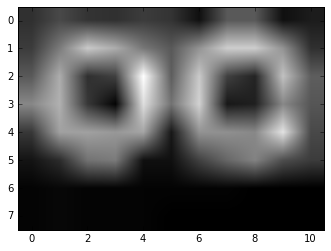

103


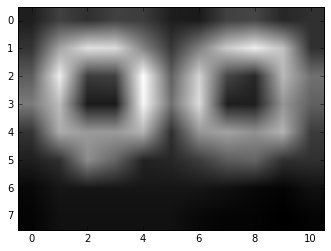

104


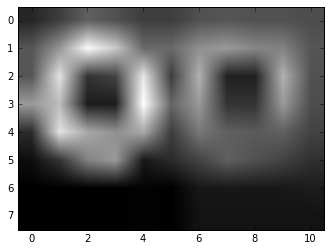

105


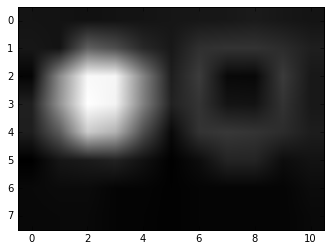

106


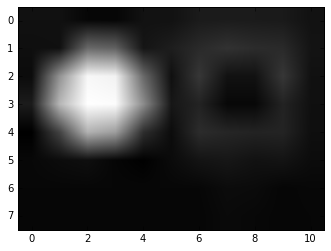

107


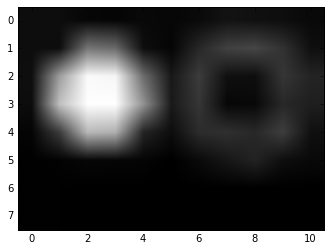

108


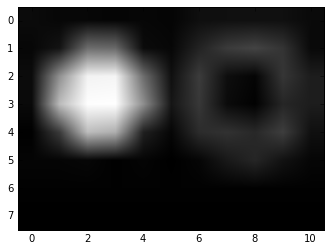

109


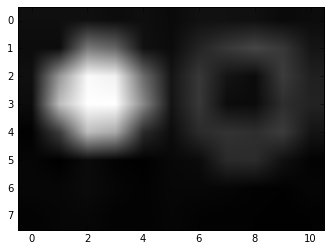

110


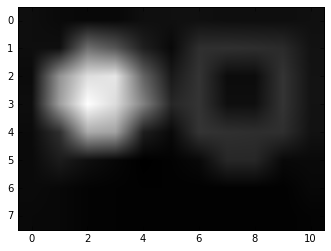

111


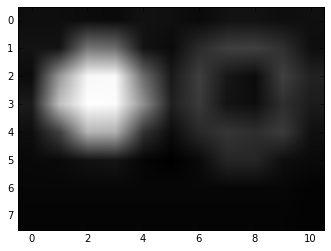

112


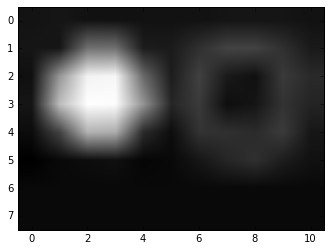

113


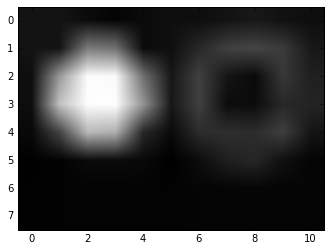

114


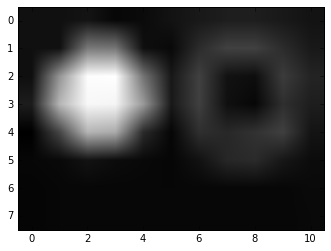

115


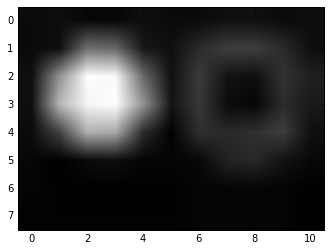

116


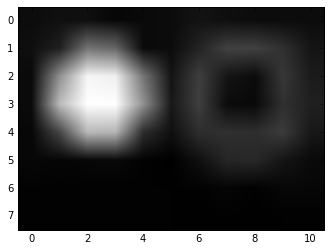

117


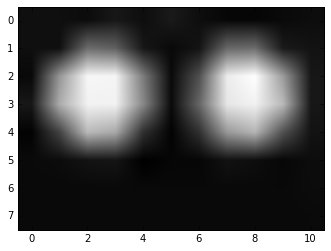

118


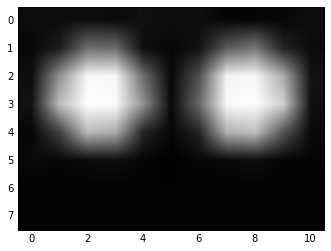

119


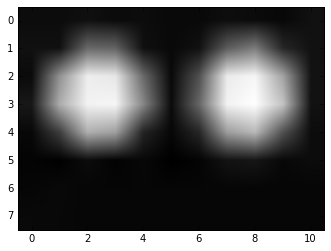

120


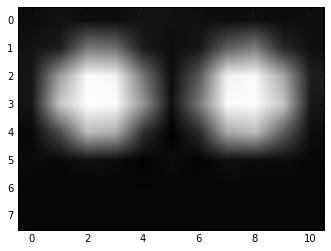

121


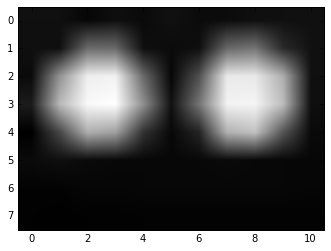

122


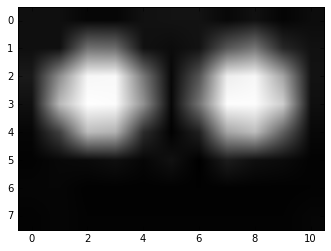

123


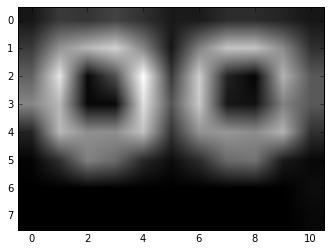

124


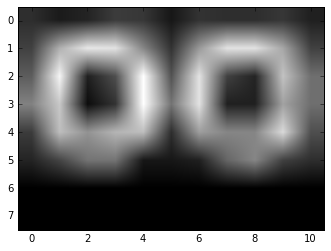

125


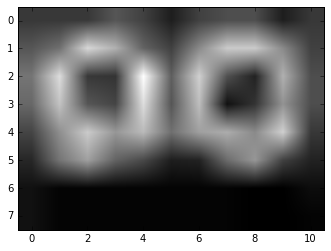

126


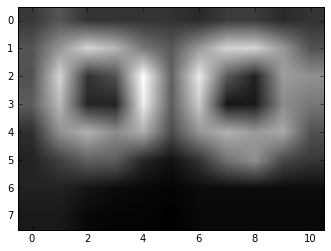

127


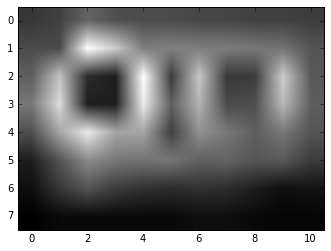

128


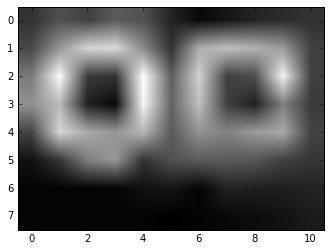

129


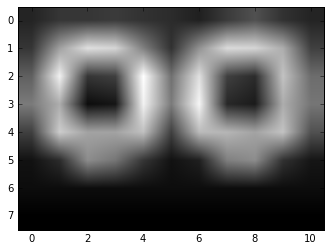

130


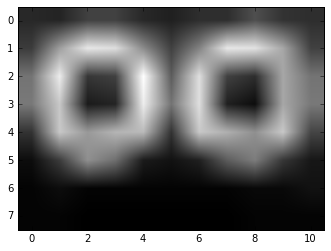

131


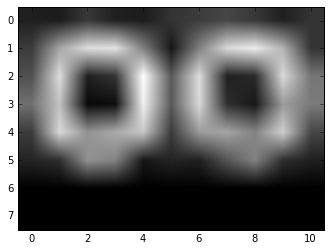

132


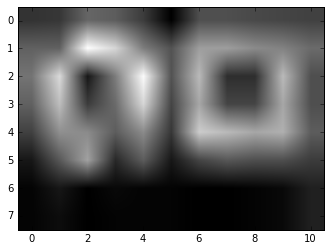

133


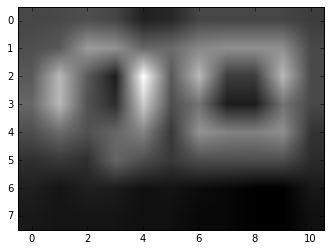

134


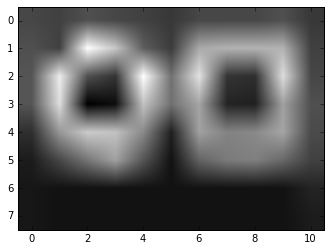

135


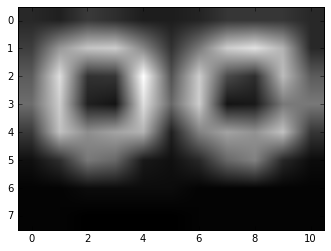

136


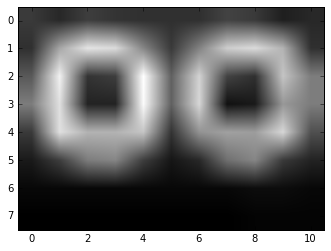

137


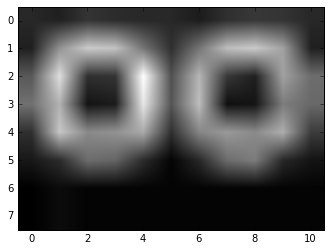

138


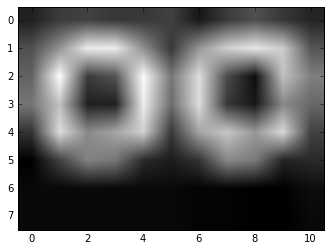

139


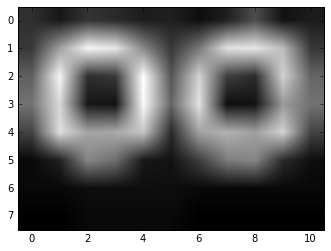

140


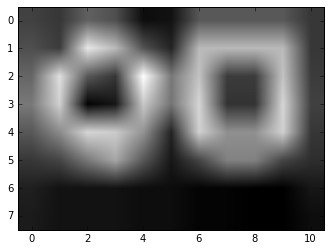

141


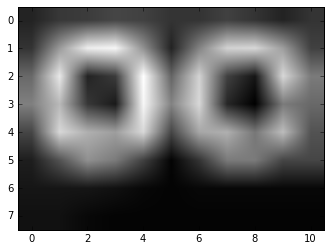

142


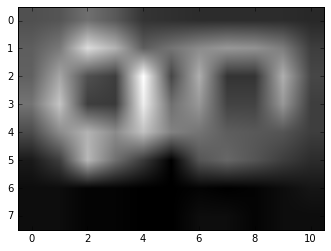

143


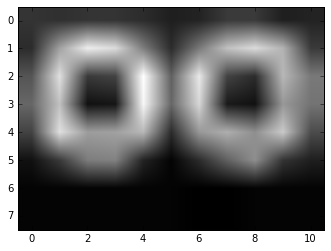

144


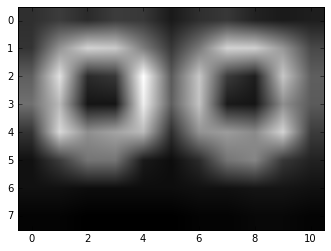

145


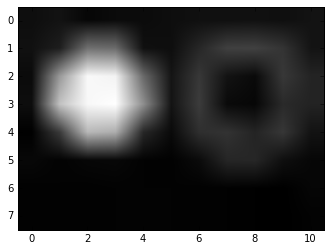

146


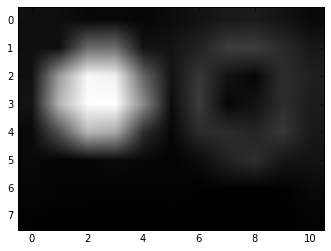

147


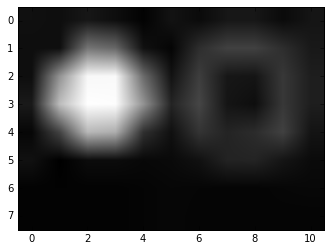

148


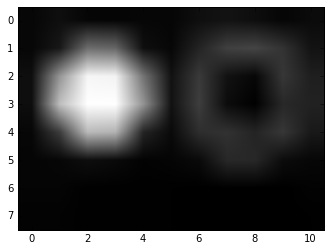

149


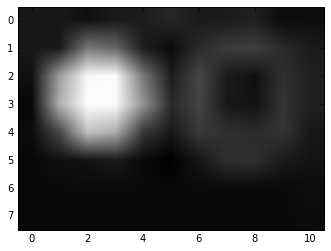

150


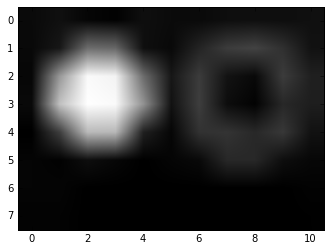

151


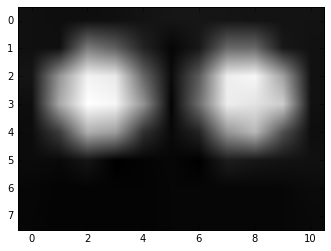

152


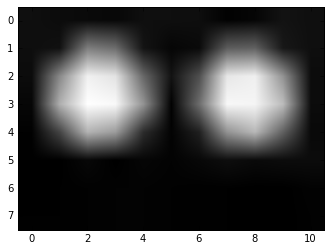

153


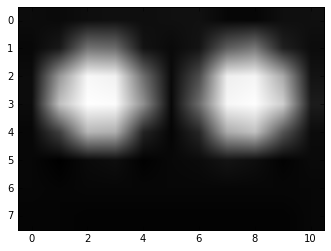

154


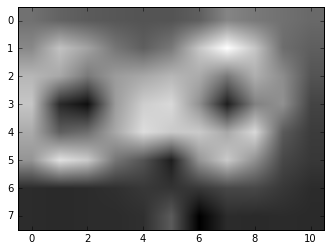

155


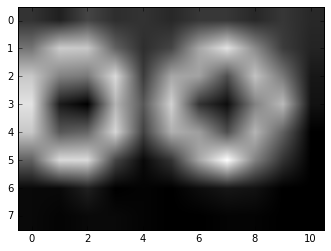

156


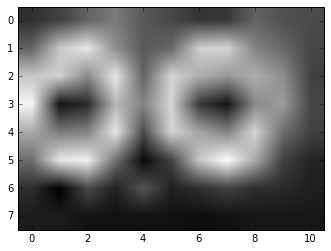

157


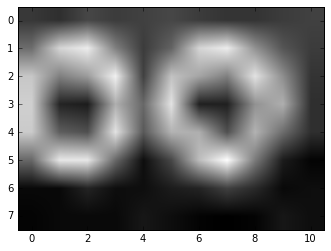

158


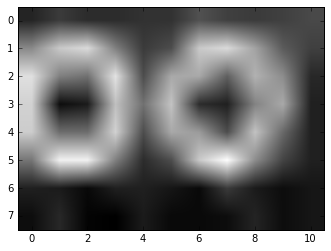

159


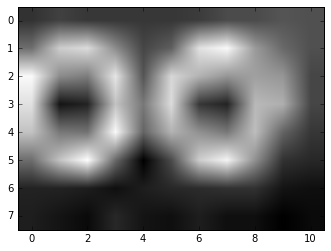

160


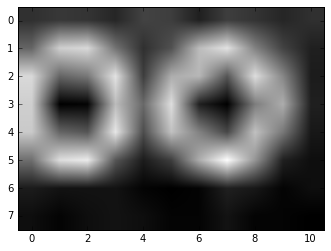

161


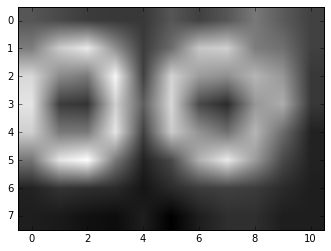

162


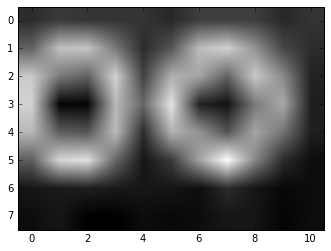

163


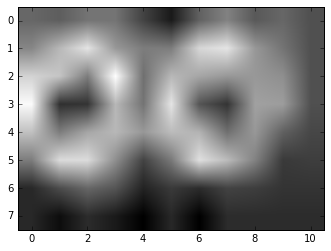

164


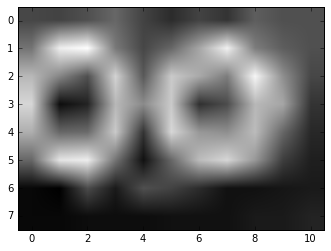

165


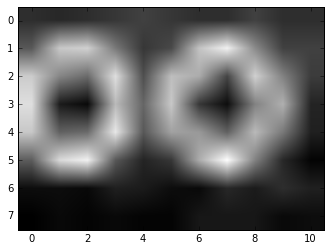

166


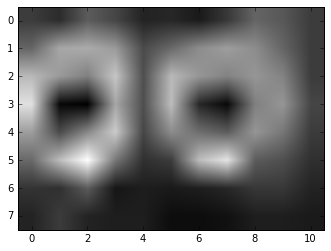

167


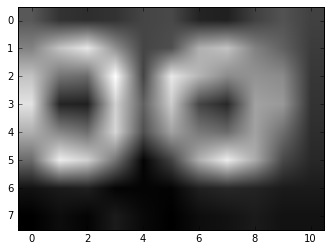

168


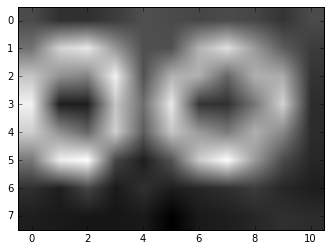

169


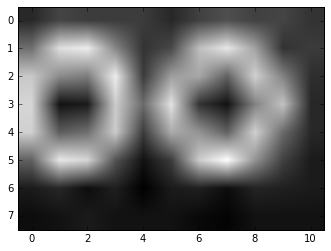

170


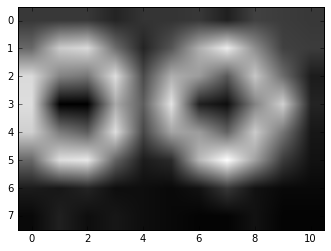

171


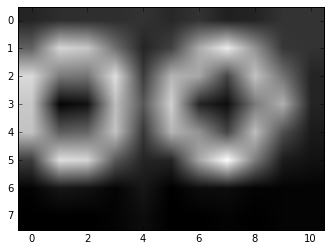

172


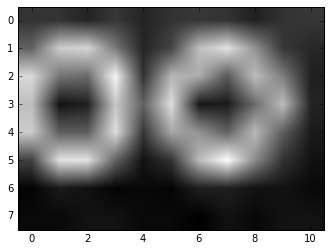

173


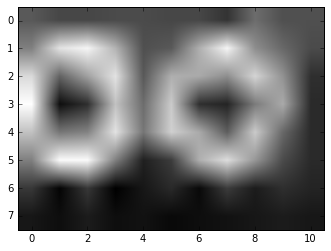

174


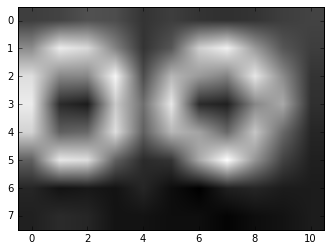

175


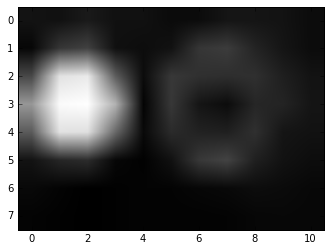

176


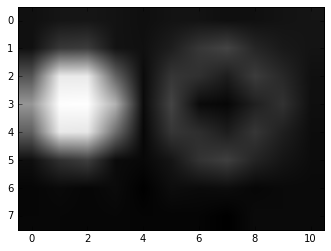

177


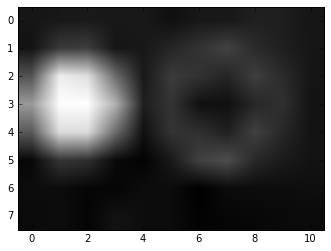

178


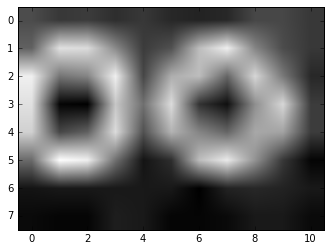

179


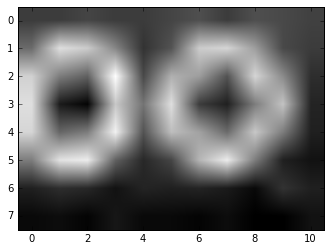

180


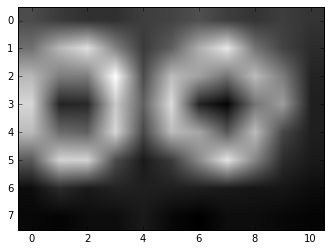

181


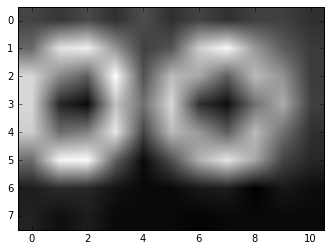

182


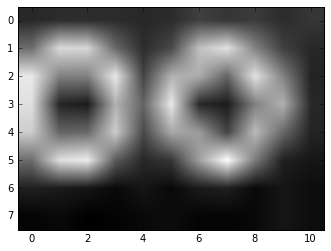

183


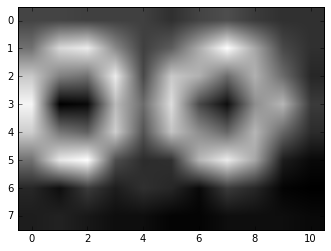

184


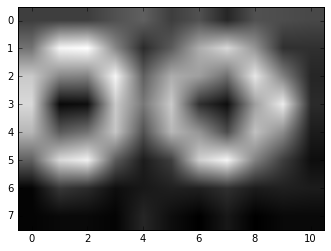

185


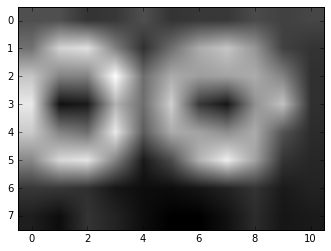

186


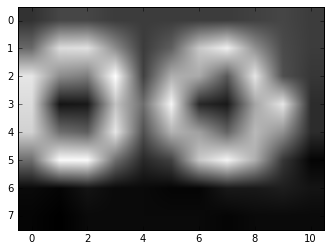

187


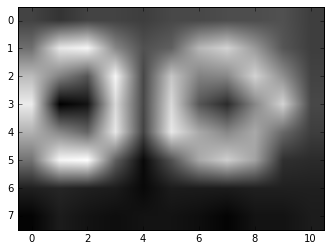

188


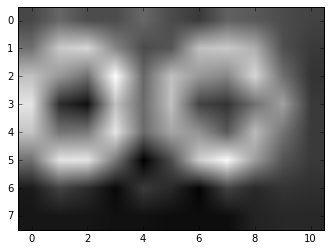

189


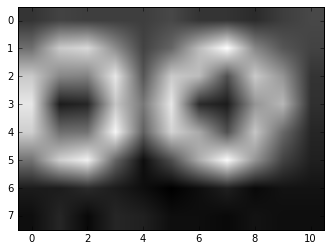

190


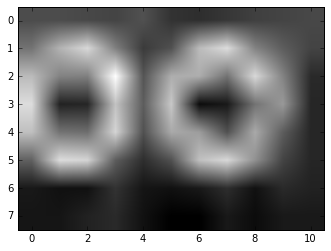

191


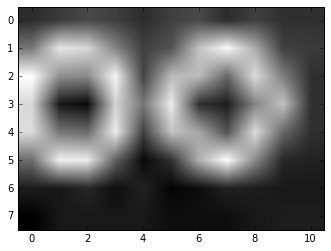

192


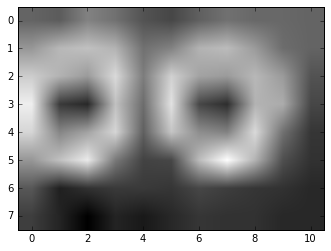

193


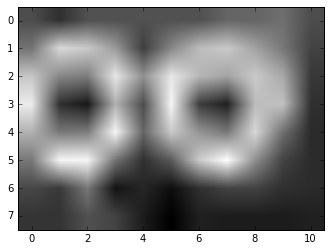

194


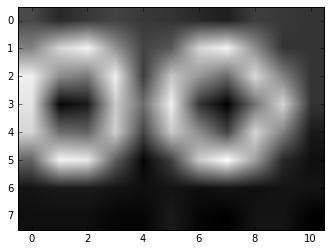

195


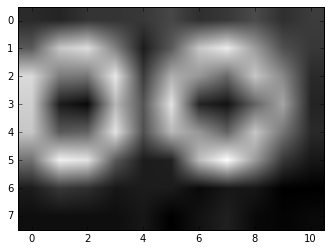

196


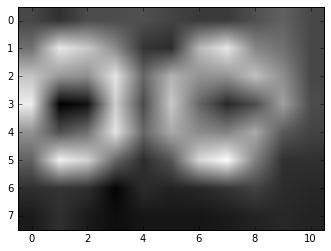

197


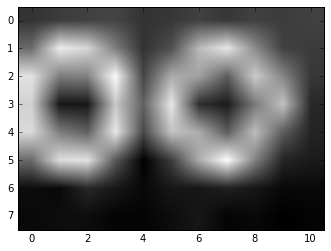

198


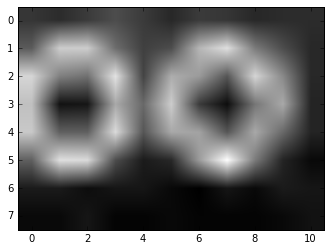

199


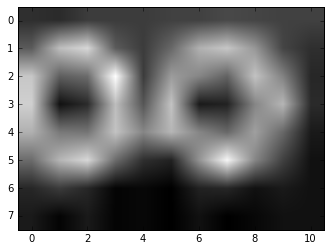

200


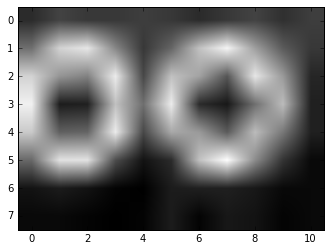

201


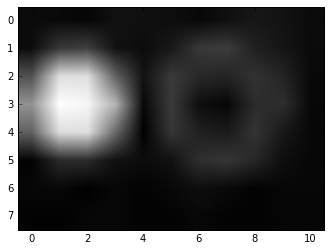

202


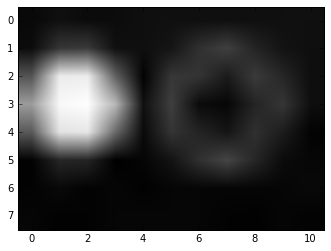

203


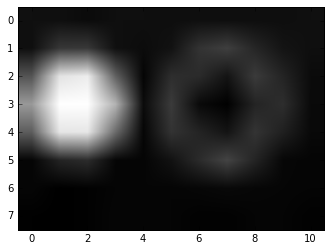

204


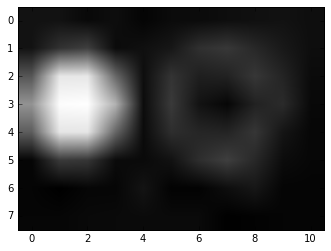

205


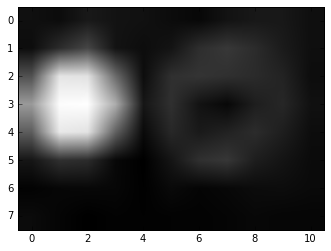

206


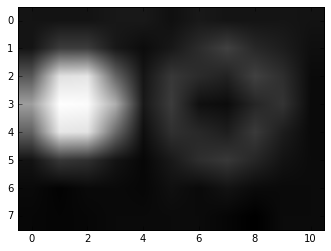

207


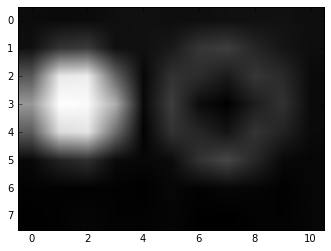

208


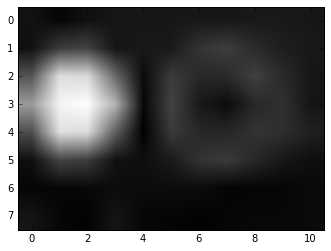

209


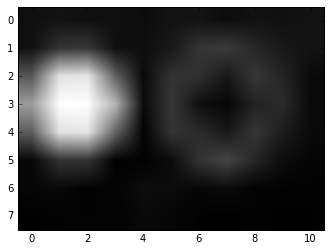

210


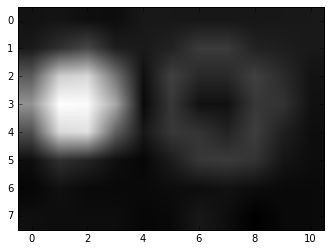

211


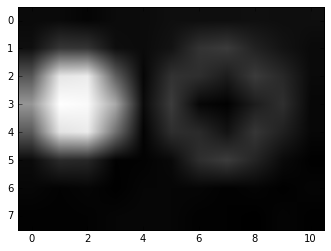

212


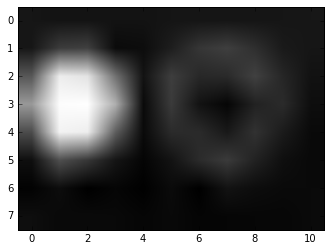

213


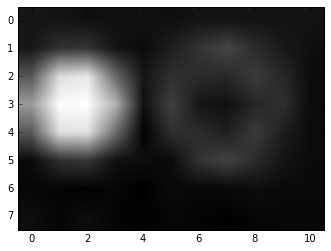

214


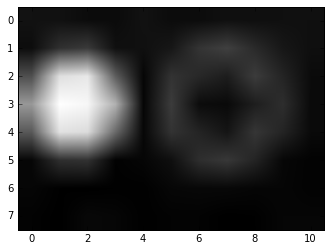

215


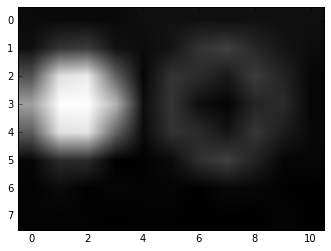

216


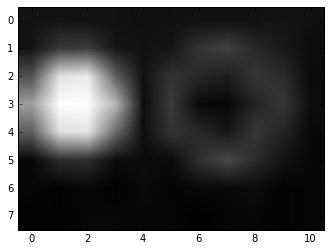

217


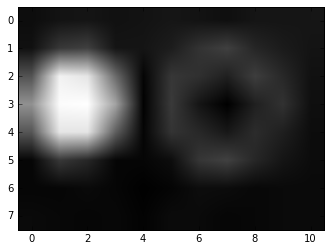

218


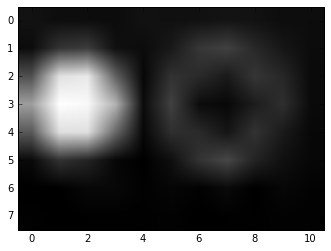

219


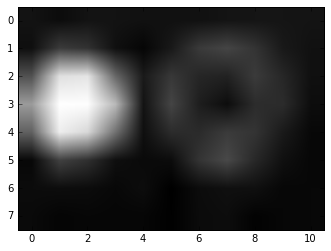

220


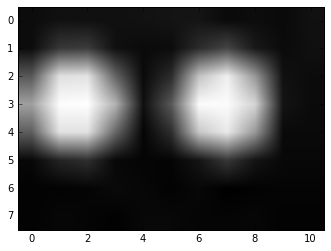

221


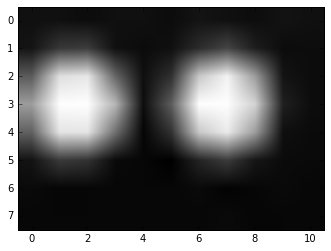

222


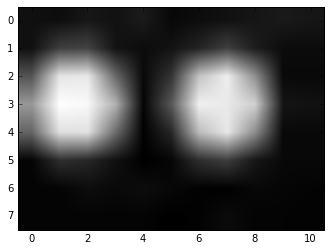

223


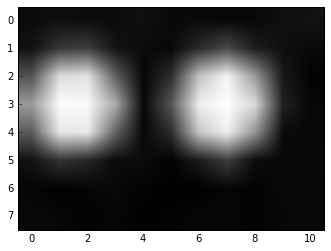

224


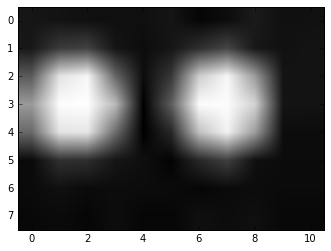

In [324]:
for i in range(len(outs)):
    print i
    plt.imshow(outs[i].reshape(8,11),cmap='gray')
    plt.show()

In [329]:
outs_labs = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 
            2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
            1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
            1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
            0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
            1, 1, 1, 1, 2, 2, 2, 2, 2]

In [333]:
outs_labs = np.array(outs_labs)

In [346]:
zip([classify_outs(o) for o in outs],outs_labs)

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 

In [332]:
pickle.dump(outs_labs, open('data/outs-labels.pkl','wb'))

In [986]:
out1 = get_count_section(ims, [20, 30], [18, 25])

In [996]:
out1 = out1[(labs1 == 2) | (labs1 == 3)]
labs1 = labs1[(labs1 == 2) | (labs1 == 3)]

In [254]:
out2 = get_count_section(ims, [20, 30], [27, 33])

In [1016]:
pca3 = PCA(n_components=2)
transformed = pca3.fit_transform(out1)

In [1017]:
neighs3 = KNeighborsClassifier(n_neighbors=3)
neighs3.fit(transformed, labs1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [966]:
rf3 = RandomForestClassifier(n_estimators=10)
rf3.fit(transformed, labs1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1020]:
pickle.dump(neighs3, open('models/two-three-clf.pkl', 'wb'))

In [1021]:
pickle.dump(pca3, open('models/two-three-pca.pkl', 'wb'))

In [965]:
test_classifier(transformed, np.array(labs1), rf3, percent=0.7)

0.98529411764705888

In [1476]:
pickle.dump([score_areas, labels], open('data/score-areas2','wb'))

In [1716]:
pickle.dump(pca, open('models/count1-pca.pkl','wb'))

In [2145]:
pickle.dump(neighs2, open('models/count2-clf.pkl','wb'))

In [2146]:
pickle.dump(pca2, open('models/count2-pca.pkl','wb'))

In [294]:
cv2.imwrite('data/score_area.jpg', score_area)

True